In [51]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime

### Extract date



In [52]:
url = 'https://www.moh.gov.sg/2019-ncov-wuhan'

content = requests.get(url).content
soup =BeautifulSoup(content, 'lxml')

In [53]:
data = soup.findAll(text=re.compile("Case Summary in Singapore \(as of .+"))


In [54]:
data

['Case Summary in Singapore (as of 03 Feb 2020, 1200h)']

In [55]:
m = re.search("(\d\d \w+ 202\d, \d+\d+h)", data[0])
date_time_str = m.group(1)
data_date_time = datetime.strptime(date_time_str, '%d %b %Y, %H%Mh').strftime('%Y-%m-%d')
data_date_time


'2020-02-03'

### Extract Dataframes

In [56]:
dfs = pd.read_html(url)

In [57]:
dfs

[                                                   0
 0  Clarifications on MisinformationWe advise memb...,
                             0    1
 0             Confirmed cases   18
 1       Cases tested negative  262
 2  Cases pending test results   32,
                0       1
 0  DORSCON Level  Yellow,
              0                                                  1
 0         Date                                              Title
 1  03 Feb 2020  No New Confirmed Cases of Novel Coronavirus In...
 2  03 Feb 2020  Ministerial Statement by Mr Lawrence Wong, Min...
 3  03 Feb 2020  Ministerial Statement by Mr Gan Kim Yong, Mini...
 4  02 Feb 2020  No New Confirmed Cases of 2019 Novel Coronavir...
 5  02 Feb 2020  Advisory for Individuals Sharing Residential S...
 6  02 Feb 2020  Singapore Tourism Board (STB) unveils targeted...
 7  01 Feb 2020  Government support for firms and workers in re...
 8  01 Feb 2020  Two More Confirmed Imported Cases of Novel Cor...
 9  01 Feb 2020  Health

In [58]:
# Look for df with confirmed cases, tested negative, ...

for df in dfs:
    combined_fields = df[0].to_string().lower()
    if "confirmed cases" in combined_fields and "cases tested" in combined_fields:
        sing_cases_df = df
        
sing_cases_df

,0,1
0,Confirmed cases,18
1,Cases tested negative,262
2,Cases pending test results,32


In [59]:

# flip the table around
sing_cases_df = sing_cases_df.set_index(0).T



In [60]:
# column name mapping
old_new_map= {'confirmed': 'confirmed', 
           'negative': 'negative',
           'pending': 'pending'}
def map_name(old_name):
    for k,v in old_new_map.items():
        if k in old_name.lower():
            return v
    return None
    
sing_cases_df.columns = sing_cases_df.columns.map(map_name)
sing_cases_df.insert(0, 'datetime', data_date_time)

df = sing_cases_df


### Save to file

In [61]:
from pathlib import Path
csv_file = 'data/singapore-cases.csv'

if Path(csv_file).exists():
    # read out the old data
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['datetime'], inplace=True)


In [62]:
df.sort_values(by=['datetime'], inplace=True)
df.to_csv(csv_file, index=False)
df

,datetime,confirmed,negative,pending
0,2020-02-02,18,240,43
1,2020-02-03,18,262,32


### Plot graph

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = 'images/singapore-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d")

df.set_index('datetime_idx', inplace=True)



In [64]:
df

,datetime,confirmed,negative,pending
datetime_idx,,,,
2020-02-02,2020-02-02,18,240,43
2020-02-03,2020-02-03,18,262,32


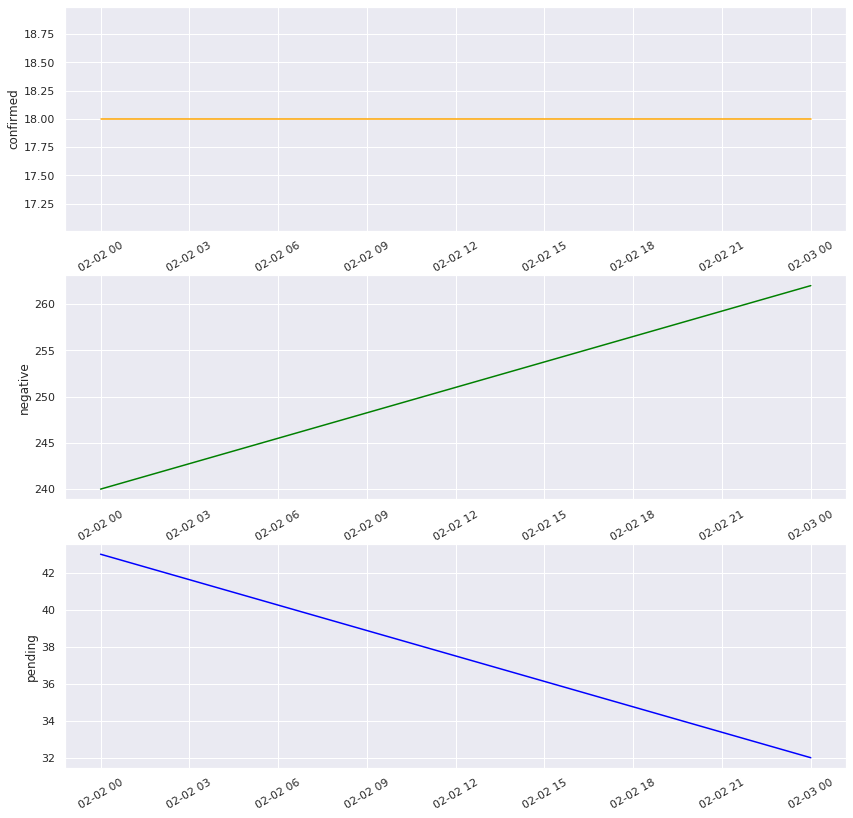

In [66]:
sns.set(rc={'figure.figsize':(14,14)})

fig, axs = plt.subplots(nrows=3)

sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
sns.lineplot(x=df.index, y = 'negative', data=df, ax= axs[1], estimator=None, color='green')
sns.lineplot(x=df.index, y = 'pending', data=df, ax= axs[2], estimator=None, color='blue')

for ax in axs:
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=30)



In [16]:
fig.savefig(png_file)